In [17]:
import numpy
import py_entropy
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
def make_mixed_experiments(n_layers=100, trials=16, num_mixed=16, num_experiments_per_trial=32, L=10, M=5):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)

    unit = numpy.array([1.0 + 0.0j])

    purities = []
    for _ in range(trials):
        choices = numpy.random.choice(numpy.arange(len(states)), replace=False, size=(num_mixed))
        chosen_states = states[choices]
        pure_states = [py_entropy.MultidefectPureState(chosen_states[[i],:], unit) for i in range(num_mixed)]
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=[(1.0/num_mixed, state) for state in pure_states], 
                                                                  n_sites=L,
                                                                  num_experiments=num_experiments_per_trial,
                                                                  skip_float_checks=True)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
    return numpy.array(purities)

In [105]:
L = 20
M = 4
states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
hilbert_d = len(states)
hilbert_d

4845

In [106]:
true_purities = []
purities = []

for num_mixed in [hilbert_d // i for i in 2**numpy.arange(1, 1+int(numpy.floor(numpy.log2(hilbert_d))))][::-1]:
    print(f"Mixing {num_mixed}")
    purities.append(make_mixed_experiments(n_layers=1000, num_mixed=num_mixed, L=L, M=M, num_experiments_per_trial=32))
    true_purities.append(1/num_mixed)
purities = numpy.array(purities)

Mixing 1
Mixing 2
Mixing 4
Mixing 9


KeyboardInterrupt: 

In [ ]:
for tp, p in zip(true_purities, purities.mean(axis=1)):
    plot_def = pyplot.plot(numpy.arange(1, len(p)+1) / L**2, p)
    pyplot.plot([1/L**2,(len(p)+1)/L**2] , [tp,tp], '--', c='gray') # c=plot_def[0].get_color())
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

for tp, p in zip(true_purities, purities.mean(axis=1)):
    pyplot.plot(numpy.arange(1, len(p)+1) / L**2, p - tp)
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

In [22]:
ne = 128
n_layers = 10000

all_purities = []

ls = 10*numpy.arange(1,11)
for l in tqdm(ls):
    state = numpy.array([1/numpy.sqrt(2)] + [0]*(l-2) + [1/numpy.sqrt(2)], dtype=numpy.complex128)
    part_on_bound = py_entropy.SingleDefectState(state, num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
pure_both_purities = numpy.array(all_purities)
    
print(f"Purity shape: {pure_both_purities.shape}")

all_purities = []

ls = 10*numpy.arange(1,11)


for l in tqdm(ls):
    all_states = []

    x = [0]*l
    x[0] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    x = [0]*l
    x[-1] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    part_on_bound = py_entropy.SingleDefectState.new_mixed([(0.5, s) for s in all_states], num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
mixed_purities = numpy.array(all_purities)

  0%|          | 0/10 [00:00<?, ?it/s]

Purity shape: (10, 10000)


  0%|          | 0/10 [00:00<?, ?it/s]

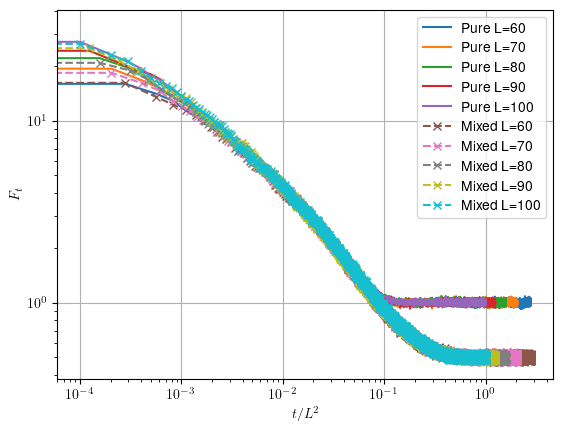

In [23]:
for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, 'x--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$F_t$')
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()

# Chunks of Dimers

We restrict to a single particle sector, the particle can be found in one of `num_mixed` sites. The purity of the state is set by how many of those pairs of sites form dimers.

In [34]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [128]:
def check_dimer_purities(L,num_mixed):
    purities = []
    true_purities = []
    
    states = numpy.arange(0,L, (L-1)//(num_mixed-1))
    
    # Go from all pure, to groups of 2, 4, etc
    
    dimer_states = []
    for dimer_size in 2**numpy.arange(0, 1+int(numpy.floor(numpy.log2(num_mixed)))):
        dimers_in_mixture = numpy.array(list(chunks(states, dimer_size)), dtype=numpy.uint64)
    
        dimers_in_mixture_states = []
        for dimer in dimers_in_mixture:
            if len(dimer.shape) == 1:
                dimer = numpy.expand_dims(dimer, axis=1)
        
            amplitudes = numpy.ones((dimer_size,),dtype=numpy.complex128)/numpy.sqrt(dimer_size)
            state = py_entropy.MultidefectPureState(dimer, amplitudes)
            dimers_in_mixture_states.append(state)
    
        mixed_state = [(1/len(dimers_in_mixture_states), state) for state in dimers_in_mixture_states] 
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=mixed_state, 
                                                                  n_sites=L,
                                                                  num_experiments=32,
                                                                  skip_float_checks=False)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
        true_purities.append(1/len(dimers_in_mixture_states))
    return numpy.array(purities), numpy.array(true_purities)

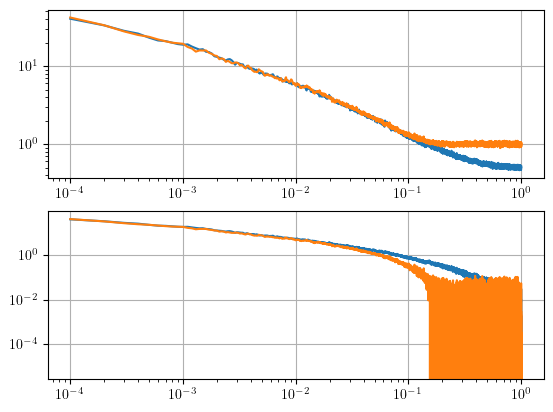

In [133]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 2)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

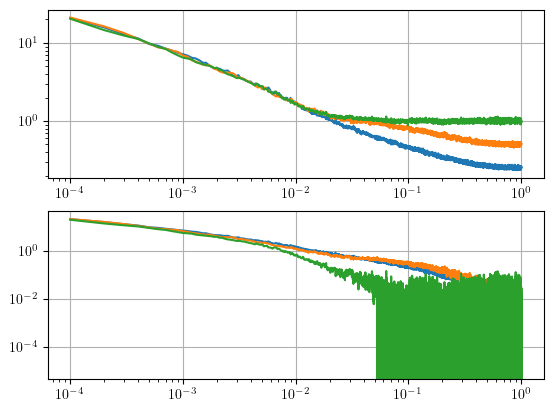

In [134]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 4)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

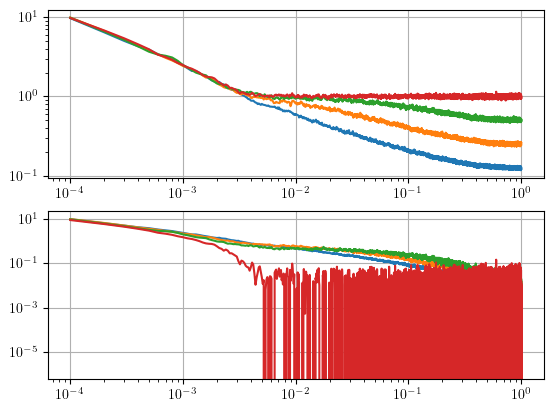

In [135]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 8)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

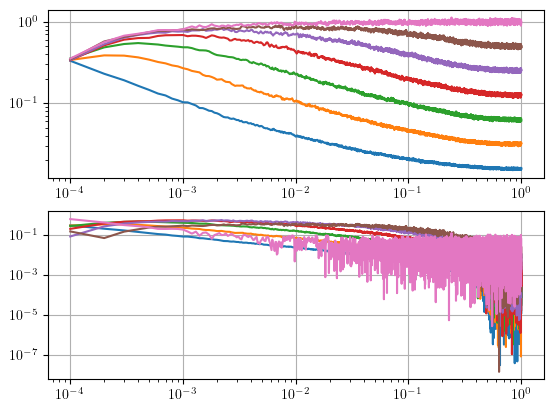

In [137]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 64)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()